# Graduated Non-Convexity (GNC) for robust spatial perceptions

The next big thing following RANSAC

Let's assume we want to do a robust fit with roboust cost function. One example is the so called Geman McClure function

In [166]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

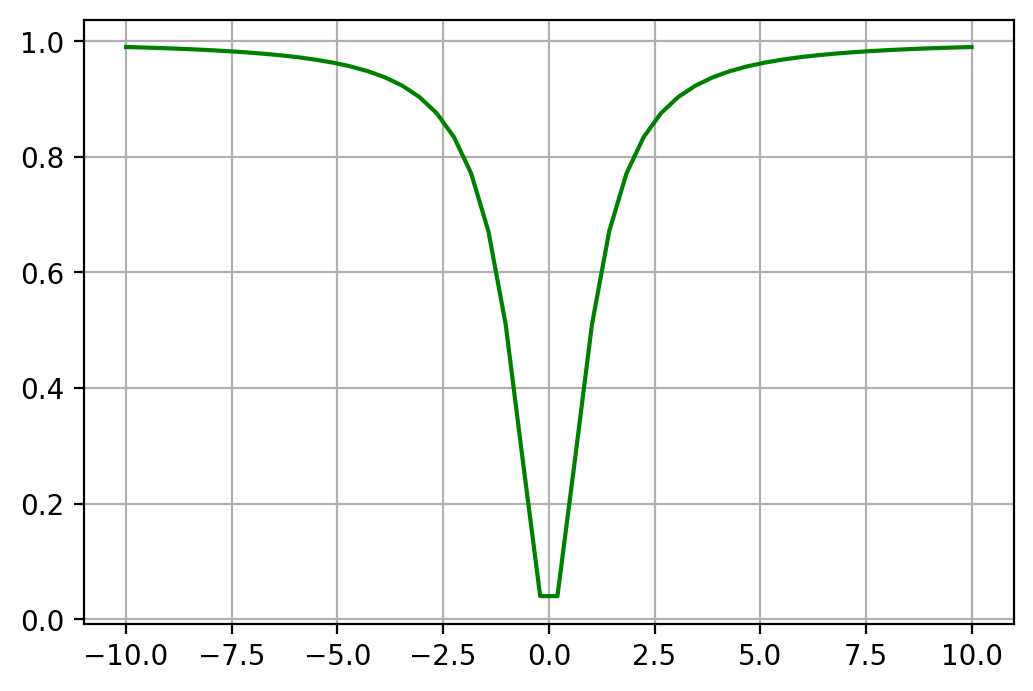

In [167]:
import numpy as np
import matplotlib.pyplot as plt

c_bar = 1

r_data = np.linspace(-10,10)
def rho_gm(c,r):
    return (c**2*r**2) / (c**2 + r**2)
c_data = rho_gm(c_bar,r_data) 

plt.plot(r_data,c_data, c = 'g')

#plt.axis('equal')
plt.grid(True)
plt.show()

OK, to start we first generate some data (with additive noise) and plot them to understand what we have got. We use a line as a model, paramtereized by [a,b,c]

outlier rate: 0.8


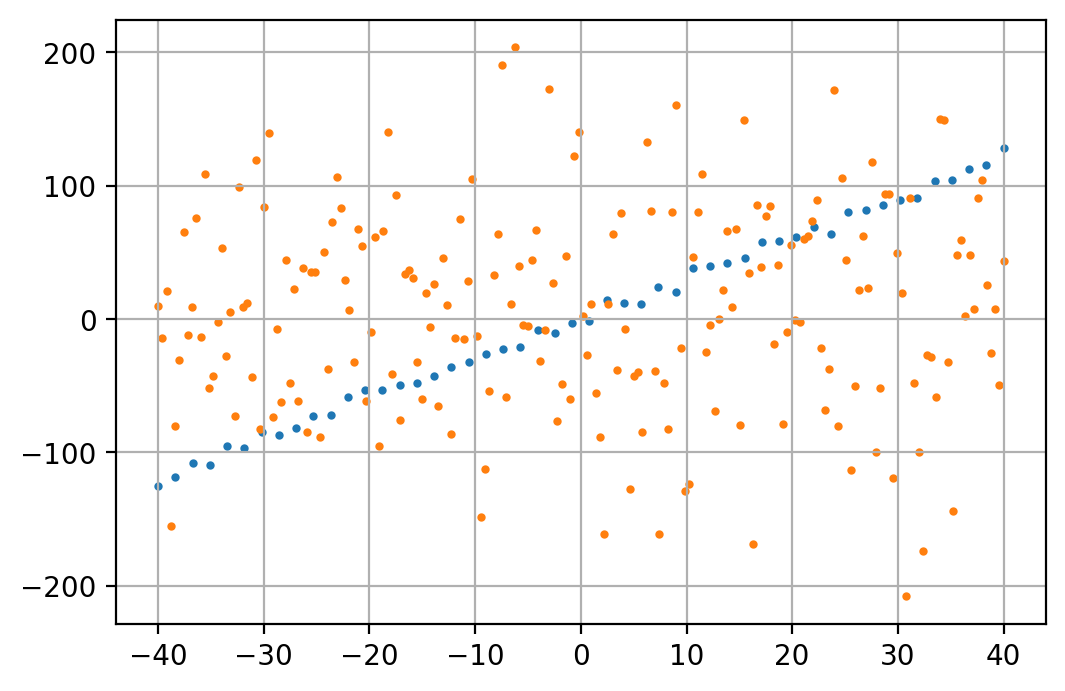

In [168]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from numpy.random import default_rng
rng = default_rng()

# let g be a kinear function of x
def linear_model(theta, x):
    return (theta[0] * x + theta[1])

#generate some inlier data
x_data = np.linspace(-40,40)
a=3; b=1; noise = 4
y_data = linear_model([a,b],x_data) + noise * rng.standard_normal(x_data.shape[0])

#generate some outliers

noise2 = 80
x2_data = np.linspace(-40,40,200)
y2_data = noise2 * rng.standard_normal(x2_data.shape[0])

print('outlier rate: ' +  repr(x2_data.size / (x_data.size + x2_data.size)))

plt.scatter(x_data,y_data, s=4)
plt.scatter(x2_data,y2_data, s=4)
#plt.axis('equal')
plt.grid(True)
plt.show()

If we fit a line, with least squares, this is what we get:

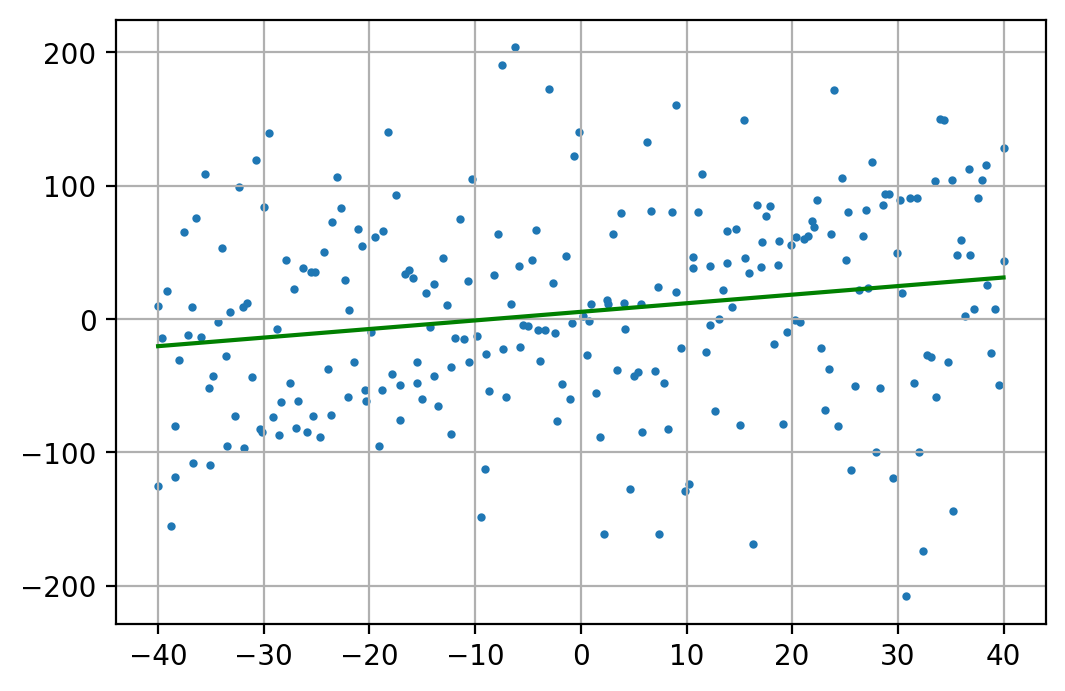

In [169]:
# setup optimization to estimate the parameters, rho is the loss function

def rho(theta,x,y,w):
    return np.sqrt(w)*(linear_model(theta, x) - y)

# do the actual optimization with both inliers and outliers
x_all = np.hstack((x_data,x2_data))
y_all = np.hstack((y_data,y2_data))
weights = np.ones_like(x_all)
theta0 = [0,1]

result = optimize.least_squares(rho, theta0, args=(x_all,y_all,weights),verbose=0)
plt.plot(x_data,linear_model(result.x,x_data), c = 'g')
plt.scatter(x_all,y_all, s=4)
#plt.axis('equal')
plt.grid(True)
plt.show()

[0.97023531 0.2421641 ]


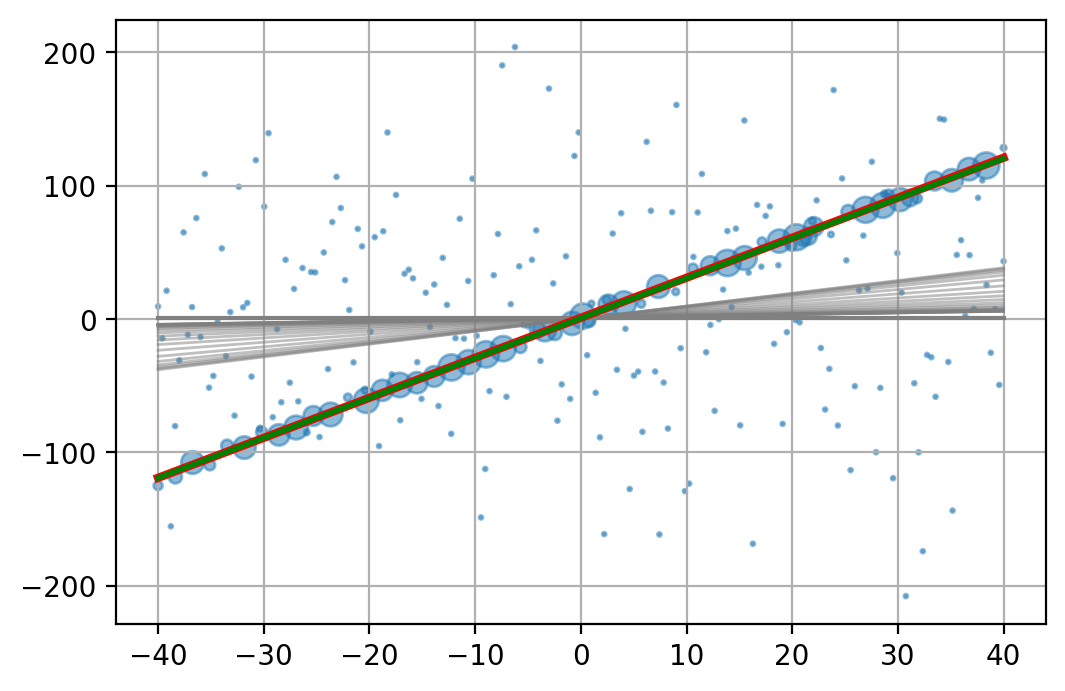

In [170]:
# setup optimization to estimate the parameters, rho is the loss function

def rho(theta,x,y,w):
    return np.sqrt(w)*(linear_model(theta, x) - y)

# do the actual optimization with both inliers and outliers
x_all = np.hstack((x_data,x2_data))
y_all = np.hstack((y_data,y2_data))
weights = np.ones_like(x_all)
theta0 = [0,1]

def weights_update(resid,c_, mu):
    return (mu*c_*c_ / (resid**2+mu*c_*c_))**2

plt.plot(x_data,linear_model(theta0,x_data), c = 'grey')
result = optimize.least_squares(rho, theta0, args=(x_all,y_all,weights),verbose=0)
residuals = linear_model(result.x, x_all) - y_all

from scipy.stats.distributions import chi2
c_bar = np.sqrt(chi2.ppf(0.8, df=2)*noise)
#c_bar = 2

mu = 2 * (np.max(residuals)**2)/(c_bar**2)
weights = weights_update(residuals,c_bar, mu)

while (mu >= 1):
    plt.plot(x_data,linear_model(theta0,x_data), c = 'grey', alpha = 0.5, linewidth=1)
    result = optimize.least_squares(rho, theta0, args=(x_all,y_all,weights),verbose=0)
    theta0 = result.x / np.linalg.norm(result.x)
    residuals = linear_model(result.x, x_all) - y_all
    #print(theta0)
    weights = weights_update(residuals,c_bar, mu)
    mu = mu / 1.4

print(theta0)
#plot the results

#plt.scatter(x_data,y_data)
#plt.scatter(x2_data,y2_data)
size = 90*weights
size[size < 2] = 2
plt.scatter(x_all,y_all, s=size, alpha=0.5)
plt.plot(x_data,linear_model([a,b],x_data), c = 'r', linewidth=3)
plt.plot(x_data,linear_model(result.x,x_data), c = 'g', linewidth=2)

#plt.axis('equal')
plt.grid(True)
plt.show()